### Miguel Fernandez-Montes
# A simple Bayesian logistic regression example - Part 1

This is the first of a two-part series of case studies in which I will use a simple data analysis example to illustrate different methods for Bayesian inference.

Until recently, I only had a very vague idea of what Bayesian inference is, and even less of a clue about Markov Chain Monte Carlo methods and other related concepts.
I realized that starting with a simple example and a fair amount of visualizations really helped me grasp the key ideas behind these Bayesian techniques.
With this case study I hope to provide precisely that.
My goal is to give a very basic notion of the Bayesian inference process, explain how some popular computational methods for Bayesian inference work and, hopefully, shed some light on why sophisticated sampling methods are needed in actual, complex scenarios.
Needless to say, I am not an expert on this matter and this really is more a part of my own learning process than an authoritative explanation of the topic.

In this first demo, I will describe the problem at hand and provide a very naïve way to perform Bayesian inference that works in very simple cases.
In the second part of the series, I will describe how more sophisticated methods work and apply them to the same example.
Let's begin!

In [1]:
%config Completer.use_jedi=False

In [27]:
import os
import numpy as np
import pandas as pd
from scipy import stats, optimize
from scipy.special import expit
import matplotlib as mpl
import matplotlib.pyplot as plt

red_color = '#E24A33'
blue_color = '#348ABD'
green_color = '#8EBA42'

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['font.size'] = 12

## A (very brief) primer on Bayesian inference

The key aspect of Bayesian inference is that it defines a full probability distribution over the quantities of interest i.e. the parameters (in parametric models) or the predictions of the target variable.
This is achieved by specifying a **sampling distribution for the data** conditioned on the parameters *and* a **prior distribution over our parameters**, which gives us, via Bayes' theorem, a **posterior distribution**:

$$ p(\theta | y) = \dfrac{p(y | \theta) p(\theta)}{\int p(y | \theta) p(\theta) d\theta } $$

where $\theta$ represents the parameters and $y$ is our data.

The integral in the denominator ($p(y)$, also known as *evidence*) is a *normalizing constant*, that does not depend on $\theta$.
Taking this into account, the posterior is usually expressed as *proportional* to the product of likelihood $p(y | \theta)$ and prior up to a multiplicative factor:

$$ p(\theta | y) \propto p(y | \theta) p(\theta) $$

Much of the inference we are interested in can be expressed as expectations of functions over the posterior distribution (think of the mean or variance, but it really could be anything).
Recall that expectations are simply integrals over the target probability distribution:

$$ \mathbb{E}[f(\theta)] = \int f(\theta)p(\theta)d\theta $$

What makes Bayesian analysis hard is precisely computing these integrals.
In most cases, there is no analytical solution to them and we need to approximate them using numerical methods, some of which we will explore here.

## The problem: Coronary Heart Disease & age

To illustrate Bayesian data analysis in action I will use a very simple example, based on data from a study (Hosmer, 2013) that measured whether subjects of different ages developed Coronary Heart Disease (CHD).

Taking a look at our data we see that for each record we have the age, age group and a binary indicator for CHD:

In [7]:
data = pd.read_csv('data/chdage.csv', index_col=0)

In [8]:
data.head()

,id,age,agegrp,chd
1,1,20,20-39,No
2,2,23,20-39,No
3,3,24,20-39,No
4,4,25,20-39,No
5,5,25,20-39,Yes


We can represent the data on a scatter plot, with age on the horizontal axis and the CHD indicator on the vertical axis (0=No CHD, 1=CHD).
As we can see, and as expected, it looks like the amount of subjects with CHD grows with age.

In [9]:
x = data['age'].values
y = (data['chd'] == 'Yes').values.astype(np.int64)

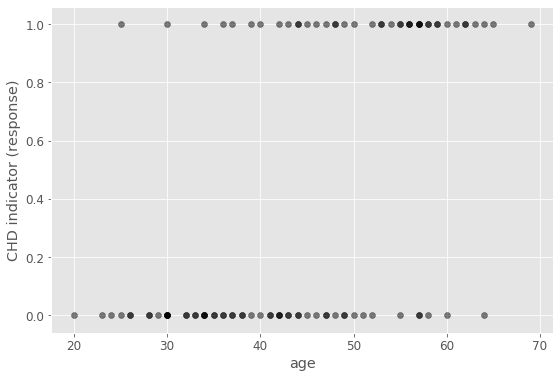

In [10]:
fig, ax = plt.subplots(1, 1)

ax.scatter(data['age'], (data['chd'] == 'Yes').astype(np.int64), alpha=0.5, color='black')
ax.set_xlabel('age')
ax.set_ylabel('CHD indicator (response)');

Now, given data like these, we might be interested in understanding the **effect of age on the likelihood of Coronary Heart Disease**.
As you may have already guessed, this example fits well with a **logistic regression model**, which allows us to "map" a continuous independent variable to a binary one.

## Logistic regression: likelihood, priors and posterior

Let us the describe our logistic regression data distribution model as follows:

$$ y_i | \alpha, \beta, x_i \sim \text{Bernouilli}(\sigma(\alpha + \beta x_i)) $$

where $\sigma(\cdot)$ is the sigmoid or inverse logit function: $\sigma(z) = \text{logit}^{-1}(z) = \frac{1}{1 + e^{-z}}$

Another way to represent this model is considering the (auxiliary) Bernouilli parameter $\theta_i$:

$$ y_i | \theta_i \sim \text{Bernouilli}(\theta_i) $$

$$ \theta_i = \sigma(\alpha + \beta x_i) = \text{logit}^{-1}(\alpha + \beta x_i) $$

In simple terms, the binary target variable $y$, which represents the presence of CHD, is Bernouilli-distributed with a parameter that depends on a single covariate $x$ i.e. the subject's age.

Note that:

* $\alpha, \beta$ are the model's parameters, which represent the relationship between the covariate $x$ and the response $y$ (basically the independent variable has a linear map to the response log-odds)
* $y_i, x_i \forall i = 1, ..., n$ are the observed responses and covariate values, for each of our $n$ subjects (which we will consider independtly distributed given their age $x_i$)

### Prior distribution
To fully specify our Bayesian model, we need to define a prior for the model's parameters $\alpha, \beta = p(\alpha, \beta)$

Following a similar example (Gelman, 2013), let us define a non-informative, uniform prior over $\alpha$ and $\beta$, as follows:

$$ p(\alpha, \beta) \propto 1 $$

*Note: using a uniform prior is not always possible! It might lead to "improper" posteriors or non-sensical results. It is typical to use weakly-informative priors instead, that include a minimum of prior information*

### Posterior distribution

Remember that we want to make inferences about the model's parameters $\alpha$ and $\beta$.
Given the above likelihood and prior, we can express the posterior distribution, up to a multiplicative factor, as:

$$ p(\alpha, \beta | y) \propto p(\alpha, \beta) p(y | \alpha, \beta) \propto \prod_{i=1}^{n} p(y_i | \alpha, \beta, x_i) = \prod_{i=1}^{n} \sigma(\alpha + \beta x_i)^{y_i} (1 - \sigma(\alpha + \beta x_i))^{1 - y_i} $$

where the likelihood is simply factored into the product of each data point's likelihood, assuming the data are i.i.d.

For computational and other purposes it is typical to work with the logarithm of the posterior:

$$ \text{log} p(\alpha, \beta | y) \propto \sum_{i=1}^{n} y_i \text{log}(\sigma(\alpha + \beta x_i)) + (1 - y_i) \text{log}(1 - \sigma(\alpha + \beta x_i)) $$

We can define likelihood, prior and posterior as Python functions, shown in the code block below:

In [11]:
def lik(y, x, alpha, beta):
    theta = expit(alpha[None, :, None] + beta[:, None, None] * x[None, None, :])
    return np.prod(theta ** y[None, None, :] * (1 - theta) ** (1 - y[None, None, :]), axis=-1)

def log_lik(y, x, alpha, beta):
    theta = expit(alpha[None, :, None] + beta[:, None, None] * x[None, None, :])
    return np.sum(np.log(theta) * y[None, None, :] + np.log(1 - theta) * (1 - y[None, None, :]), axis=-1)
            
def prior(alpha, beta):
    return 1

def log_prior(alpha, beta):
    return 0

def posterior(y, x, alpha, beta, prior, lik):
    return prior(alpha, beta) * lik(y, x, alpha, beta)

def log_posterior(y, x, alpha, beta, log_prior, log_lik):
    return log_prior(alpha, beta) + log_lik(y, x, alpha, beta)

## A naïve approach: evaluating the posterior on a grid of points

As simple as this model might be, the posterior distribution above does not have a closed-form solution from which we can readily sample or evaluate its properties (as it would be the case with well-known distributions such as the Gaussian).

Let's say we want to give a 90% posterior probability interval for each of our parameters or find out their posterior mean (or in general any inference we might want to conduct).
How do we use our (unnormalized) posterior density in order to make inferences about our model's parameters?

One naïve approach is to **evaluate the posterior for several possible parameter values**, normally referred to as a **grid** of parameter values, and use that discrete set of evaluations as an approximation to the actual posterior.
Using grid evaluation, we could empirically calculate the parameters' mean, standard deviation and other quantities of interest.
More formally, this is equivalent to approximating expectations (integrals) using a *quadrature* rule:

$$ \mathbb{E}[f(\theta)] = \int f(\theta)p(\theta)d\theta \approx \sum_{s=1}^S w_s f(\theta_s) p(\theta_s) $$

where $w_s$ are *weights* that represent the area or volume of parameter space around the $s-th$ grid point.

In general, there are some challenges with this approach.
First, it does not scale to higher dimensions, that is, to models with more parameters.
In high-dimensional settings the number of parameter-space points required to cover a sufficient part of the actual posterior increases drastically.
This is yet another incarnation of the *curse of dimensionality*.
In this case we only have two parameters to estimate, which makes grid evaluation feasible.

That said, there is a second challenge, which is defining the grid of points itself.
Ideally, we would like to have enough posterior evaluations to capture a substantial part of the actual posterior distribution.
What should be the range of the parameter grid?
And what should be the grid's granularity?

To answer these last two questions, we can use a coarse estimate of the parameters values, based on their **maximum likelihood estimate**, and define the grid around that point.

The code-block below uses SciPy's ```minimize``` method to find the minimum of the negative log-likelihood for our example, which turns out to be:

$$ \alpha_{MLE}, \beta_{MLE} = (-5.3, 0.11) $$

In [12]:
def log_lik_objective(arr, x, y):
    alpha, beta = arr
    theta = expit(alpha + beta * x)
    return np.sum(np.log(theta) * y + np.log(1 - theta) * (1 - y))

res = optimize.minimize(lambda arr: (-1) * log_lik_objective(arr, x=x, y=y),
                        x0=np.array([0, 0]),
                        method='L-BFGS-B')

alpha_mle, beta_mle = res.x

After some tweaking and experimenting, we define our grid centered at the MLE estimate of $(-5.3, 0.11)$ over $\alpha \in [-10, -1]$ and $\beta \in [0.03, 0.21]$.
We create a 200-by-200 grid over these ranges of values.
Let's visualize the posterior over this 2D grid, as well as the marginal distributions for both $\alpha$ and $\beta$, which are simply calculated by summing the posterior values over the appropriate axis.

As you can see, the distribution is more or less centered around the MLE.
From this visualization we can also gather how uncertain we are about our parameters, and the degree of correlation between them, which in this case is quite high.

Like we would expect, age has a positive relationship with the probability of CHD, encoded in the parameter $\beta$, with a very high probablity (pretty much all of the posterior mass), although there is some uncertainty around the actual strength of that connection.
The intercept term $\alpha$ is a bit harder to interpret, since the "probability of CHD at age 0" does not really make a lot of sense for this use-case.

In [14]:
alphas = np.linspace(-10, -1, 200)
betas = np.linspace(0.03, 0.21, 200)
alphas_grid, betas_grid = np.meshgrid(alphas, betas)

posterior_grid = posterior(y, x, alphas, betas, prior=prior, lik=lik)

In [15]:
marginal_alpha = posterior_grid.sum(axis=0)
marginal_alpha = marginal_alpha / marginal_alpha.sum()
marginal_cdf_alpha = marginal_alpha.cumsum() / marginal_alpha.sum()

marginal_beta = posterior_grid.sum(axis=1)
marginal_beta = marginal_beta / marginal_beta.sum()
marginal_cdf_beta = marginal_beta.cumsum() / marginal_beta.sum()

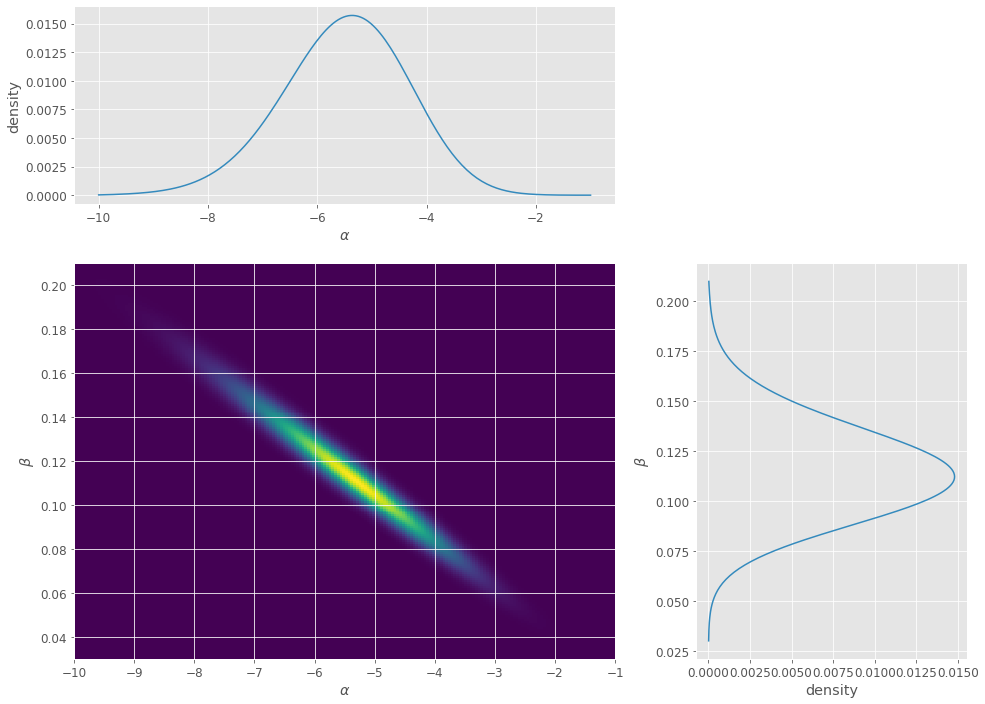

In [16]:
fig, axes = plt.subplots(2, 2,
                         figsize=(16, 12),
                         gridspec_kw=dict(
                             width_ratios=[2, 1],
                             height_ratios=[1, 2]))

ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

ax2.axis('off')

ax1.plot(alphas, marginal_alpha, color=blue_color)
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('density')

ax4.plot(marginal_beta, betas, color=blue_color)
ax4.set_xlabel('density')
ax4.set_ylabel(r'$\beta$')

ax3.imshow(posterior_grid,
           origin='lower',
           aspect='auto',
           extent=(alphas[0], alphas[-1], betas[0], betas[-1]))
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel(r'$\beta$');

We can produce approximate samples from the posterior by sampling each grid point with probability proportional to its density value and adding some small jitter, as shown in the scatter plot on the left side, below.
For each sampled parameter pair $\alpha_s, \beta_s$ we can visualize the resulting logistic curve on top of our data, as you can see in the plot to the right.
One particular posterior sample and corresponding curve has been highlighted in red for illustration purposes
This way, we can get an idea, not only of the distribution of our model's parameters, but of the kind of predictions we would make with them i.e. of the possible logistic curves that could fit our data, with varying probabilities.
In addition, we can find the *mean* curve and construct probability intervals for our logistic curve, which give us an idea of the uncertainty in predicting the probability of CHD for a given subject based on their age.

In [47]:
n_samples = 500
alpha_jitter = (alphas.max() - alphas.min()) / (alphas.shape[0] * 2)
beta_jitter = (betas.max() - betas.min()) / (betas.shape[0] * 2)

alpha_samples = []
beta_samples = []
curves = []

ages = np.linspace(15, 75)

for i in range(n_samples):
    z = np.random.uniform(size=1)
    if marginal_cdf_alpha.min() > z:
        continue
    idx_alpha_s = np.where(marginal_cdf_alpha < z)[0][-1]
    alpha_s = alphas[idx_alpha_s]
    
    marginal_cond_beta = posterior_grid[:, idx_alpha_s]
    marginal_cond_cdf_beta = marginal_cond_beta.cumsum() / marginal_cond_beta.sum()
        
    w = np.random.uniform(size=1)
    if marginal_cond_cdf_beta.min() > w:
        continue
    idx_beta_s = np.where(marginal_cond_cdf_beta < w)[0][-1]
    beta_s = betas[idx_beta_s]

    alpha_s += np.random.uniform(-alpha_jitter, alpha_jitter, size=1)
    beta_s += np.random.uniform(-beta_jitter, beta_jitter, size=1)

    alpha_samples.append(alpha_s)
    beta_samples.append(beta_s)
    
    curves.append(expit(alpha_s + beta_s * ages))

alpha_samples = np.array(alpha_samples)
beta_samples = np.array(beta_samples)
    
curves_arr = np.stack(curves, axis=0)
curve_p05 = np.percentile(curves_arr, 5, axis=0)
curve_p95 = np.percentile(curves_arr, 90, axis=0)
curve_mean = curves_arr.mean(axis=0)

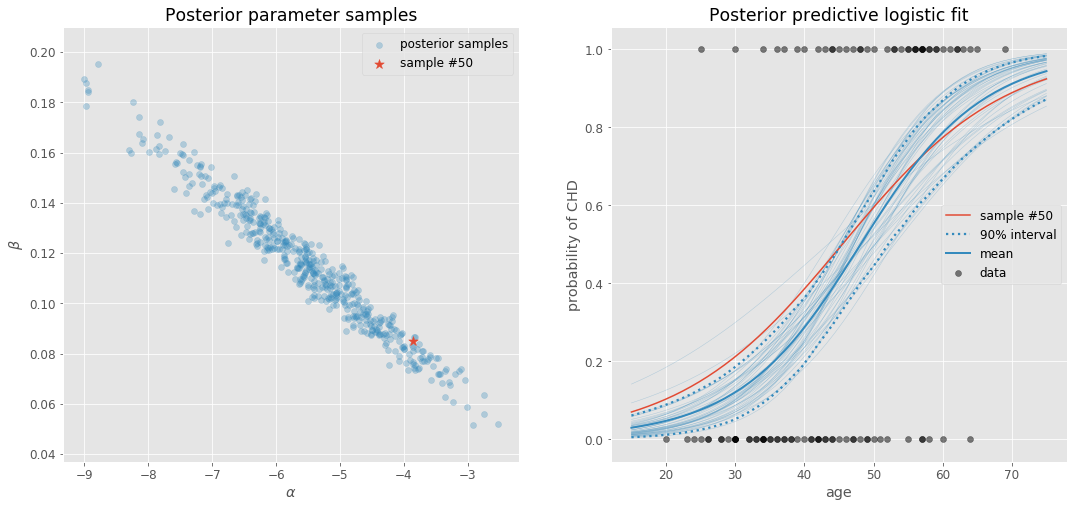

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

alpha_samples_ = [sample for i, sample in enumerate(alpha_samples) if i != 50]
beta_samples_ = [sample for i, sample in enumerate(beta_samples) if i != 50]

ax1.scatter(alpha_samples_, beta_samples_, color=blue_color, alpha=0.3, label='posterior samples')
ax1.scatter(alpha_samples[50], beta_samples[50], marker='*', s=100, color=red_color, label='sample #50')

ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$\beta$')
ax1.set_title('Posterior parameter samples')
ax1.legend()

ax2.scatter(x, y, alpha=0.5, color='black', label='data')
ax2.plot(ages, curves_arr[:50, :].T, alpha=0.3, color=blue_color, linewidth=0.5)
ax2.plot(ages, curves_arr[50, :].T, color=red_color, linewidth=1.5, label='sample #50')
ax2.plot(ages, curve_p05, color=blue_color, linestyle=':', linewidth=2.25)
ax2.plot(ages, curve_p95, color=blue_color, linestyle=':', linewidth=2.25, label='90% interval')
ax2.plot(ages, curve_mean, color=blue_color, linewidth=2, label='mean')

ax2.set_xlabel('age')
ax2.set_ylabel('probability of CHD')
ax2.set_title('Posterior predictive logistic fit')
ax2.legend();

The procedure described above, by which we visualize the *data* distribution *averaged over* possible values of the parameters from our posterior is an approximation of the **posterior predictive distribution**, more formally:

$$ p(\tilde{y} | y) = \int p(\tilde{y} | \theta)p(\theta | y) d\theta $$

Bayesian analysis allows us to account for the uncertainty in our knowledge of the parameters when making predictions about unseen instances, which is, in my view, a very powerful concept.

With the ability to sample from our posterior, we can answer all sorts of questions, beyond the simple parameter inferences and predictive visualizations above.
For example, we might be interested in understanding what the **probability of CHD for a subject of age 60** is, as shown in the histogram below.
According to our model and data the probability of developing CHD for a 60-year old subject (from the population from which our data was gathered) seems to lie between 66.7% and 88.9% with 90% probability.

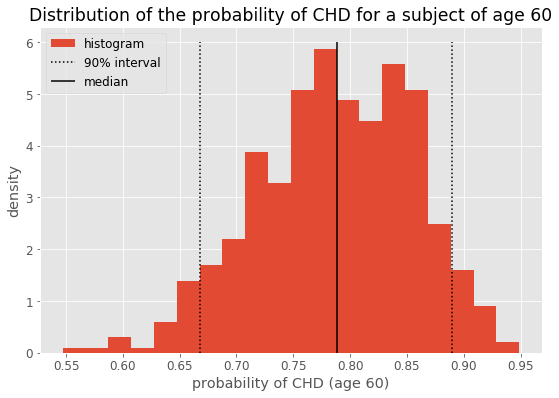

In [80]:
age_value = 60
chd_prob = expit(alpha_samples + beta_samples * age_value).squeeze()

fig, ax = plt.subplots(1, 1)

ax.hist(chd_prob,
        bins=20,
        density=True,
        label='histogram')
ax.vlines(np.percentile(chd_prob, [5, 95]),
          ymin=0,
          ymax=6,
          linestyle=':',
          label='90% interval')
ax.vlines(np.median(chd_prob),
          ymin=0,
          ymax=6,
          label='median')
ax.set_xlabel('probability of CHD (age 60)')
ax.set_ylabel('density')
ax.set_title('Distribution of the probability of CHD for a subject of age 60')
ax.legend();

We might also want to understand what the **age at which the probability of CHD reaches around 50%** is, which, given our model, is simply the ratio $-\frac{\alpha}{\beta}$.
We can easily use our posterior samples to construct a histogram for this particular quantity, as shown below.
In this case, our posterior tells us that the median age at which the probability of CHD equals 50% is roughly 48 years-old.

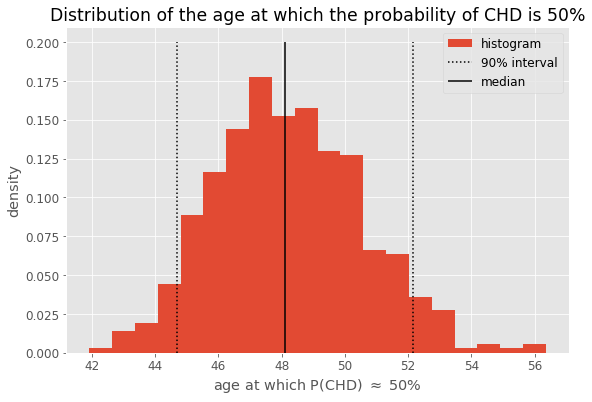

In [85]:
ratios = (-1) * alpha_samples / beta_samples

fig, ax = plt.subplots(1, 1)

ax.hist(ratios,
        bins=20,
        density=True,
        label='histogram')
ax.vlines(np.percentile(ratios, [5, 95]),
          ymin=0,
          ymax=0.2,
          linestyle=':',
          label='90% interval')
ax.vlines(np.median(ratios),
          ymin=0,
          ymax=0.2,
          label='median')
ax.set_xlabel(r'age at which P(CHD) $\approx$ 50%')
ax.set_ylabel('density')
ax.set_title('Distribution of the age at which the probability of CHD is 50%')
ax.legend();

It would be fair to question whether these inferences are reasonable.
Given the above, our model might lead us to believe that Coronary Heart Disease is *way more likely* than we might think.
We would need to understand how our data were sampled and what population are our inferences valid for.

That said, this example simply aims to illustrate how Bayesian inference works, at its most basic.
Without going into whether these inferences regarding CHD are reasonable or not, I hope that these examples show how Bayesian data analysis provides us with powerful tools to represent the uncertainty around our estimates.

## Summary and take-aways

To summarize, we have walked through a fairly simple data analysis example to show how Bayesian inference works.
The key idea behind Bayesian data analysis is that **we define probability distributions over both data $y$ and parameters $\theta$, and we make inferences about our parameters (and any other quantity, including future predictions) through the posterior probability distribution $p(\theta | y)$**.

In this simple case, we have used a straightforward evaluation of the posterior in a discrete set of possible parameter values. However, this naïve method based on a grid-evaluation of our posterior is less than ideal.
We have already seen that some tweaking was required to construct the parameter grid and grid-evaluation is completely impractical the moment we scale up to slightly more complex models.

In the next part of this series, while keeping the same simple logistic regression example, we will look at other methods based on *sampling*, with a particular focus on some relevant MCMC methods, that will allow us to make posterior inferences in a much more efficient way.

***

You can check out the code used to generate this report on [my GitHub]()

## References

Hosmer, D.W., Lemeshow, S. and Sturdivant, R.X. (2013) Applied Logistic Regression, 3rd ed., New York: Wiley

Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D., Vehtari, A. & Rubin, D. B. (2013). Bayesian data analysis (3rd ed). Chapman & Hall/CRC